# Увеличение выручки интернет-магазина

В нашем распоряжении данные с гипотезами по увеличению выручки, а также данные по заказам и посетителям.

Соответственно, в данном проекте поставлено две основные задачи:

1. приоритизировать имеющиеся гипотезы, 
2. проанализировать данные A/B-теста.

## Описание данных

**Таблица `hypothesis`:**
- `Hypothesis` — краткое описание гипотезы
- `Reach` — охват пользователей по 10-балльной шкале
- `Impact` — влияние на пользователей по 10-балльной шкале
- `Confidence` — уверенность в гипотезе по 10-балльной шкале
- `Efforts` — затраты ресурсов на проверку гипотезы по 10-балльной шкале

**Таблица `orders`:**
- `transactionId` — идентификатор заказа
- `visitorId` — идентификатор пользователя, совершившего заказ
- `date` — дата, когда был совершен заказ
- `revenue` — выручка заказа
- `group` — группа A/B-теста, в которую попал заказ.

**Таблица `visitors`:**
- `date` — дата
- `group` — группа A/B-теста
- `visitors` — количество пользователей в указанную дату в указанной группе A/B-теста.

## Структура работы
**Приоритизация гипотез**

1. [Приоритизация гипотез и сравнение методов приоритизации](#prioritisation)

**Анализ A/B-теста**

1. [Загрузка данных и первый взгляд](#orders_import)
    - [Вывод](#sum_up_1)
2. [Кумулятивные метрики](#cumulative_metrics)
    - [Выручка](#revenue)
    - [Средний чек](#check)
    - [Конверсия](#conversion)
    - [Вывод](#sum_up_2)
4. [Количество и стоимость заказов. Анализ выбросов](#orders)
    - [Вывод](#sum_up_3)
5. [Сравнение групп](#comparison)
    - [конверсия по "сырым" данным](#conversion_rough)
    - [конверсия по "очищенным" данным](#conversion_clean)
    - [средний чек по "сырым" данным](#check_rough)
    - [средний чек по "очищенным" данным](#check_clean)
    - [Вывод](#sum_up_4)

[Общий вывод](#sum_up)

<a id='prioritisation'></a>
## Приоритизация гипотез и сравнение методов приоритизации

Посмотрим, какие гипотезы есть, применим к ним фреймворки приоритизации ICE и RICE.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import datetime as dt

In [2]:
hypothesis = pd.read_csv('hypothesis.csv')

In [3]:
pd.set_option('display.max_columns', None)
pd.options.display.max_colwidth = 150  
hypothesis

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


Приведем названия столбцов к нижнему регистру.

In [4]:
hypothesis.columns = [i.lower() for i in hypothesis.columns]

In [5]:
hypothesis

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


In [6]:
hypothesis['ice'] = (hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts']
hypothesis['rice'] = (hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts']

In [7]:
hypothesis[['hypothesis', 'ice']].sort_values(by='ice', ascending=False).round()

,hypothesis,ice
8,"Запустить акцию, дающую скидку на товар в день рождения",16.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.0
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.0
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.0


In [8]:
hypothesis[['hypothesis', 'rice']].sort_values(by='rice', ascending=False)

,hypothesis,rice
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


In [9]:
(hypothesis[['hypothesis', 'ice', 'rice']]
       .round()
       .sort_values(by='rice', ascending=False)
       .style
       .background_gradient(cmap=sns.light_palette("green", as_cmap=True)))

,hypothesis,ice,rice
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.000000,112.000000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.000000,56.000000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.000000,40.000000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.000000,40.000000
8,"Запустить акцию, дающую скидку на товар в день рождения",16.000000,16.000000
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.000000,9.000000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.000000,4.000000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.000000,4.000000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.000000,3.000000


Согласно фреймворку **ICE** в первую очередь следует проверить гипотезу **8** — **"Запустить собственную службу доставки, что сократит срок доставки заказов"**. Однако в фреймворке **RICE** эта гипотеза имеет всего лишь 5-й приоритет ввиду своего малого охвата. Если учитывать охват, то **7** гипотеза **"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок"** выделяется на фоне других за счет воздействия на всю аудиторию ресурса.

<a id='orders_import'></a>
## Анализ A/B-теста

## Загрузка данных и первый взгляд

In [10]:
orders = pd.read_csv('orders.csv')
visitors = pd.read_csv('visitors.csv')

In [11]:
orders.head(10)

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
5,182168103,935554773,2019-08-15,2210,B
6,398296753,2900797465,2019-08-15,1860,B
7,2626614568,78758296,2019-08-15,1044,A
8,1576988021,295230930,2019-08-15,13710,A
9,1506739906,1882260405,2019-08-15,1855,B


In [12]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


В базе нет пропусков, все типы данных, кроме даты считались корректно. Проверим данные на корректность - есть ли отрицательные значения в столбце `revenue`.

In [13]:
orders[orders['revenue'] < 0]

,transactionId,visitorId,date,revenue,group


In [14]:
visitors.head(10)

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
5,2019-08-06,A,667
6,2019-08-07,A,644
7,2019-08-08,A,610
8,2019-08-09,A,617
9,2019-08-10,A,406


In [15]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


Во второй таблице так же отсутствуют пропуски, типы данных, за исключением даты, определены верно. Исправим дату в обеих таблицах.

In [16]:
orders['date'] = orders['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
visitors['date'] = visitors['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

In [17]:
ordersA = orders[orders['group'] == 'A']['visitorId'].unique()
ordersB = orders[orders['group'] == 'B']['visitorId'].unique()
duplicates = np.intersect1d(ordersA, ordersB)
len(duplicates)

58

В данных о заказах 58 пользователей одновременно попали как в группу A, так и в группу B. Этих пользователей нужно исключить из наблюдений.

In [18]:
len(orders['visitorId'].unique())

1031

In [19]:
orders = orders[~orders['visitorId'].isin(duplicates)]
1031 - len(orders['visitorId'].unique())

58

Было 1031 уникальных пользователей, после удаления дублей стало на 58 меньше, значит операция прошла успешно.

<a id='sum_up_1'></a>
### Вывод

- Данные в обеих таблицах корректны, пропуски отсутствуют, столбцы с датой приведены к нужному формату, остальные типы данных считались верно.
- В таблице с заказами 58 пользователей попали в обе группы, данные о заказах по этим пользователям были удалены.

<a id='cumulative_metrics'></a>
## Кумулятивные метрики


В этом блоке рассчитаем кумулятивные метрики по группам:

- выручка
- средний чек
- конверсия

In [20]:
# Создаем уникальные пары дата-группа
datesGroups = orders[['date','group']].drop_duplicates()

In [21]:
# Считаем кумулятивные данные по заказам для каждой группы
ordersAggregated = (datesGroups
      .apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]
      .agg({
          'date' : 'max',
          'group' : 'max',
          'transactionId' : pd.Series.nunique,
          'visitorId' : pd.Series.nunique,
          'revenue' : 'sum'
          }), axis=1)
      .sort_values(by=['date','group'])
      )

In [22]:
# Считаем кумулятивные данные по посетителям для каждой группы
visitorsAggregated = (datesGroups
      .apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])]
      .agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1)
      .sort_values(by=['date','group'])
      )

In [23]:
# Объединяем две таблицы и правим названия столбцов
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

<a id='revenue'></a>
### Выручка

In [24]:
# Создаем отдельную таблицу с кумулятивными данными выручки для каждой группы
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

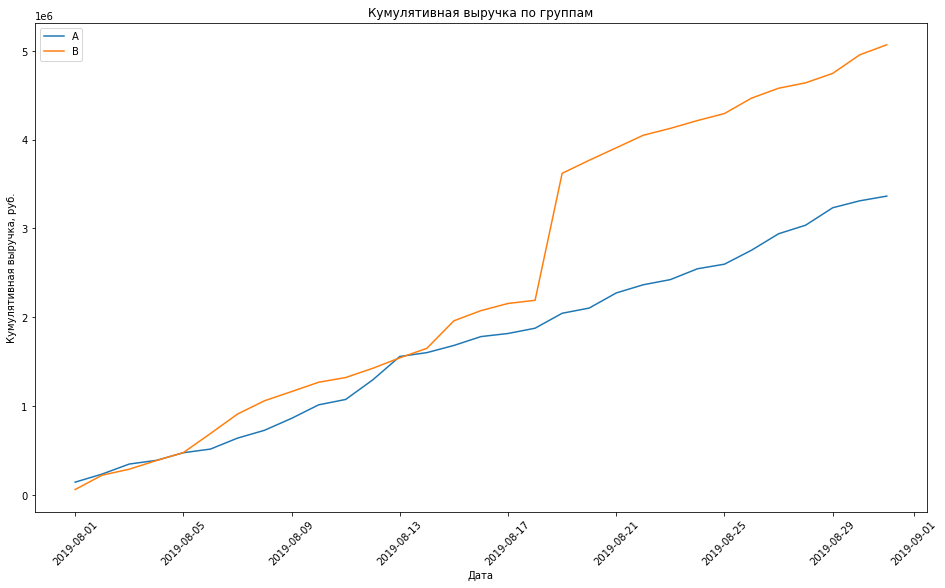

In [25]:
plt.figure(figsize=(16,9))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')
plt.xticks(rotation=45)
plt.title('Кумулятивная выручка по группам')
plt.xlabel('Дата')
plt.ylabel('Кумулятивная выручка, руб.')
plt.legend();

Группа B на протяжении всего теста, за исключением первого дня, приносила большую выручку по сравнению с группой A. При этом в середине тесте у группы B заметен выраженный скачок, что свидетельствует о наличии выброса в данных - заказа с нетипично высокой суммой.

<a id='check'></a>
### Средний чек

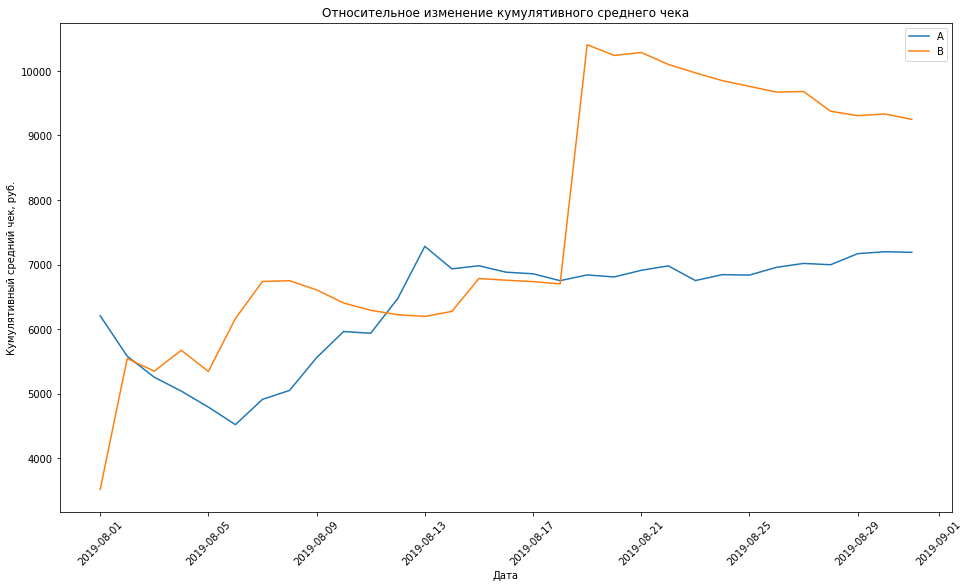

In [26]:
plt.figure(figsize=(16,9))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.xticks(rotation=45)
plt.title('Относительное изменение кумулятивного среднего чека')
plt.xlabel('Дата')
plt.ylabel('Кумулятивный средний чек, руб.')
plt.legend();

График относительно изменения кумулятивного среднего чека так же показывает выброс в группе B в середине теста.

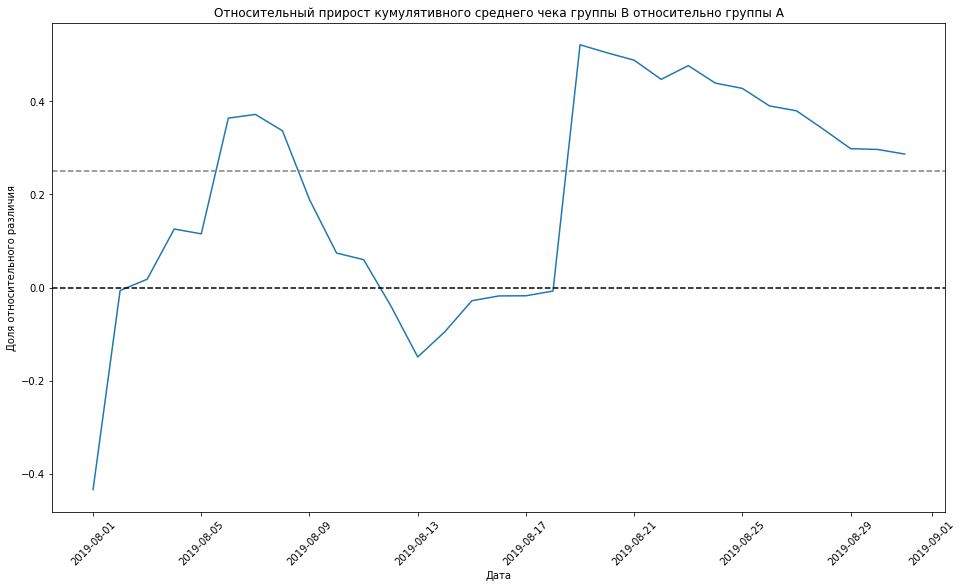

In [27]:
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB,
                                                   left_on='date',
                                                   right_on='date',
                                                   how='left',
                                                   suffixes=['A', 'B'])
plt.figure(figsize=(16,9))
plt.plot(mergedCumulativeRevenue['date'],
    (mergedCumulativeRevenue['revenueB'] /\
        mergedCumulativeRevenue['ordersB'])/\
    (mergedCumulativeRevenue['revenueA']/\
        mergedCumulativeRevenue['ordersA']) - 1)
plt.xticks(rotation=45)
plt.title('Относительный прирост кумулятивного среднего чека группы В относительно группы А')
plt.xlabel('Дата')
plt.ylabel('Доля относительного различия')
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.25, color='grey', linestyle='--');

Относительный прирост кумулятивного среднего чека группы B по отношению к группе A нестабилен. До скачка, связанного с возможным выбросом этот показатель для группы B вовсе был отрицательным. 

<a id='conversion'></a>
### Конверсия

In [28]:
# Создаем таблицы с конверсией по группам
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

cumulativeDataA = cumulativeData[cumulativeData['group']=='A']
cumulativeDataB = cumulativeData[cumulativeData['group']=='B'] 

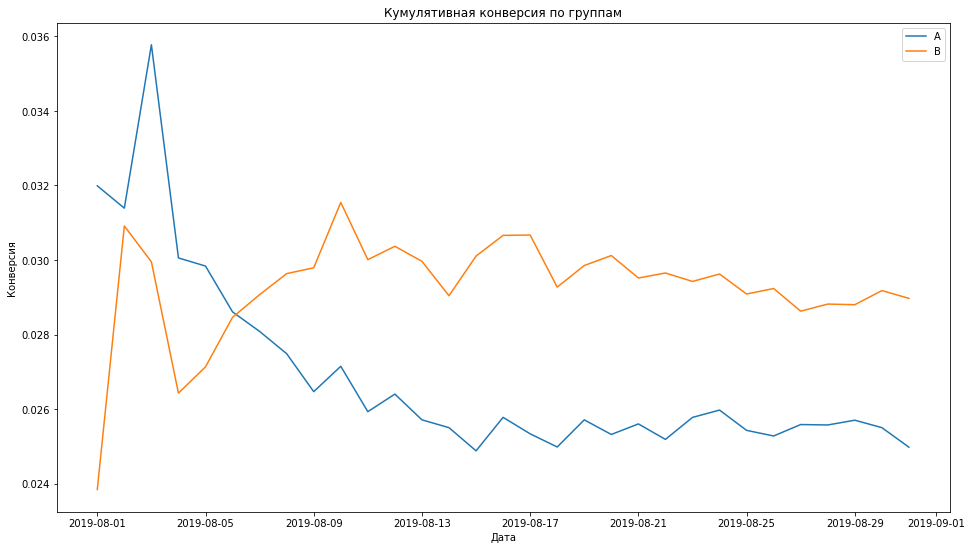

In [29]:
plt.figure(figsize=(16,9))
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.title('Кумулятивная конверсия по группам')
plt.xlabel('Дата')
plt.ylabel('Конверсия')
plt.legend();

Различие между двумя группами стабилизировалось на 8-й день теста, однако определенное значение так и не установилось ни в одной из групп. В обеих группах к концу теста видна тенденция к снижению конверсии. Максимальное различие между двумя группами достигало около 0,7%.

In [30]:
mergedCumulativeConversions = (cumulativeDataA[['date','conversion']]
                                 .merge(cumulativeDataB[['date','conversion']],
                                        left_on='date',
                                        right_on='date',
                                        how='left',
                                        suffixes=['A', 'B']))

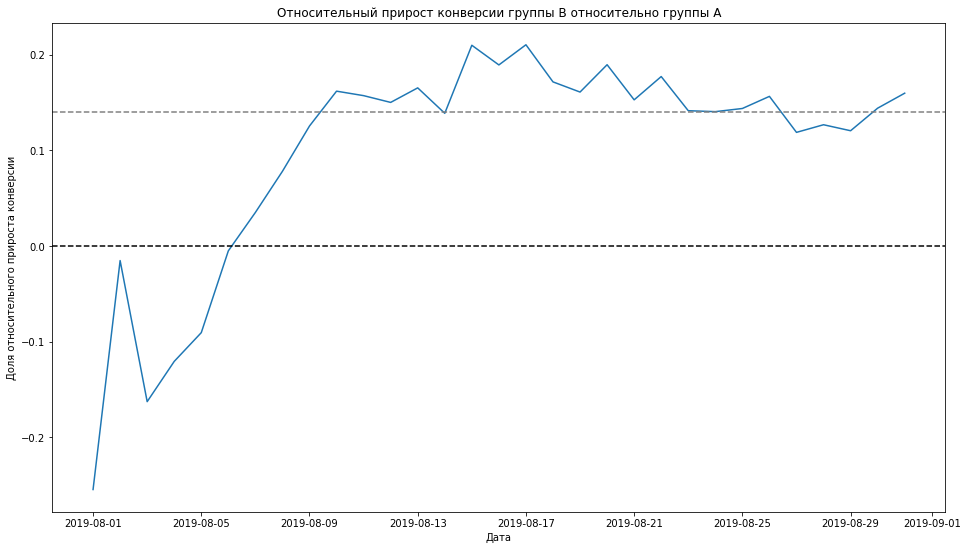

In [31]:
plt.figure(figsize=(16,9))
plt.plot(mergedCumulativeConversions['date'],
    mergedCumulativeConversions['conversionB'] /\
    mergedCumulativeConversions['conversionA'] - 1)
plt.title('Относительный прирост конверсии группы B относительно группы A')
plt.xlabel('Дата')
plt.ylabel('Доля относительного прироста конверсии')
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.14, color='grey', linestyle='--');

Относительно группы A конверсия группы B к концу теста стала на 14% выше, с 10 августа относительное различие конверсии стабилизировалось.

<a id='sum_up_2'></a>
### Вывод

- В данных присутствуют выбросы, которые искажают результаты. Так, в группе B 18-19 августа был совершен заказ на нетипично большую сумму.
- Выручка в группе B выше, начиная со второго дня теста.
- Средний чек в двух группах сильно колеблется, к концу теста относительно группы A кумулятивный средний чек группы B был выше на 25%.
- Конверсия группы B стабильно выше конверсии группы A, однако внутри групп конверсия в ходе теста не установилась на конкретном значении.

<a id='orders'></a>
## Количество и стоимость заказов. Анализ выбросов

- Постройте точечный график количества заказов по пользователям. Сделайте выводы и предположения.
- Посчитайте 95-й и 99-й перцентили количества заказов на пользователя. Выберите границу для определения аномальных пользователей.
- Постройте точечный график стоимостей заказов. Сделайте выводы и предположения.
- Посчитайте 95-й и 99-й перцентили стоимости заказов. Выберите границу для определения аномальных заказов.

In [32]:
ordersByUsers = (orders
      .drop(['group', 'revenue', 'date'], axis=1)
      .groupby('visitorId', as_index=False)
      .agg({'transactionId' : pd.Series.nunique})
      )
ordersByUsers.columns = ['visitorId','orders']

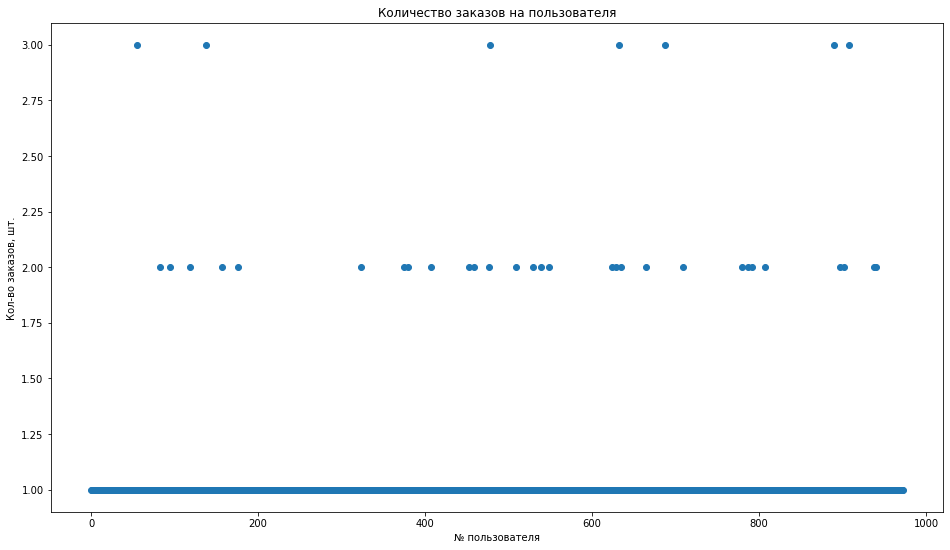

In [33]:
plt.figure(figsize=(16,9))
x_values = pd.Series(range(0,len(ordersByUsers)))
plt.title('Количество заказов на пользователя')
plt.xlabel('№ пользователя')
plt.ylabel('Кол-во заказов, шт.')
plt.scatter(x_values, ordersByUsers['orders']);

Большинство посетителей совершают не более одного заказа, единицы покупают более 3 раз.

In [34]:
print(np.percentile(ordersByUsers['orders'], [95, 99])) 

[1. 2.]


Всего 1% офорил заказ более 2 раз. Сохраним это значение в переменную `normal_orders_n` для последующего исключения выбросов.

In [35]:
normal_orders_n = np.percentile(ordersByUsers['orders'], 99)

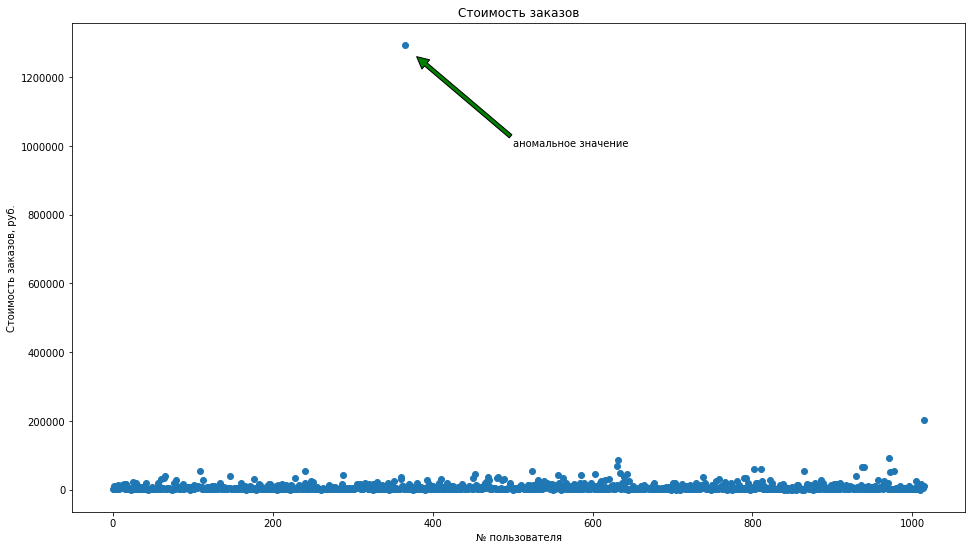

In [36]:
plt.figure(figsize=(16,9))
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.ticklabel_format(style = 'plain')
plt.title('Стоимость заказов')
plt.xlabel('№ пользователя')
plt.ylabel('Стоимость заказов, руб.')
plt.annotate('аномальное значение', xy=(380, 1260000), xytext=(500, 1000000),
            arrowprops=dict(facecolor='g'))
plt.scatter(x_values, orders['revenue']);

In [37]:
print(np.percentile(orders['revenue'], [95, 99])) 

[26785. 53904.]


99% заказов не превышают 54 тыс. руб., при этом есть заказ более, чем на 1,2 млн. руб. Скорее всего, именно этот заказ искажал данные в предыдущем блоке. Сохраним 99-й перцентиль в переменную `normal_price`.

In [38]:
normal_price = np.percentile(orders['revenue'], 99)

<a id='sum_up_3'></a>
### Вывод

В данных небольшое количество выбросов. В основном люди совершают до 4 заказов и тратят не более 58 тыс. руб. за один заказ. Есть выброс в размере 1,2 млн. руб., что существенно искажает результаты анализа.

<a id='comparison'></a>
## Сравнение групп

In [39]:
visitorsADaily = visitors[visitors['group']=='A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = (visitorsADaily
      .apply(lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']]
      .agg({'date' : 'max', 'visitorsPerDateA' : 'sum'}), axis=1)
      )
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

In [40]:
visitorsBDaily = visitors[visitors['group']=='B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = (visitorsBDaily
      .apply(lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']]
      .agg({'date' : 'max', 'visitorsPerDateB' : 'sum'}), axis=1)
      )
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

In [41]:
ordersADaily = (orders[orders['group']=='A'][['date', 'transactionId', 'visitorId', 'revenue']]
      .groupby('date', as_index=False)
      .agg({'transactionId' : pd.Series.nunique, 'revenue' : 'sum'}))
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = (ordersADaily
      .apply(lambda x: ordersADaily[ordersADaily['date'] <= x['date']]
      .agg({
          'date' : 'max', 
          'ordersPerDateA' : 'sum',
          'revenuePerDateA' : 'sum'
          }), axis=1)
      .sort_values(by=['date'])
      )
ordersACummulative.columns = ['date', 'ordersCummulativeA', 'revenueCummulativeA']

In [42]:
ordersBDaily = (orders[orders['group']=='B'][['date', 'transactionId', 'visitorId', 'revenue']]
      .groupby('date', as_index=False)
      .agg({'transactionId' : pd.Series.nunique, 'revenue' : 'sum'})
      )
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = (ordersBDaily
      .apply(lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']]
      .agg({
          'date' : 'max',
          'ordersPerDateB' : 'sum',
          'revenuePerDateB' : 'sum'}), axis=1)
      .sort_values(by=['date'])
      )
ordersBCummulative.columns = ['date', 'ordersCummulativeB', 'revenueCummulativeB']

In [43]:
data = (ordersADaily
      .merge(ordersBDaily, left_on='date', right_on='date', how='left')
      .merge(ordersACummulative, left_on='date', right_on='date', how='left')
      .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
      .merge(visitorsADaily, left_on='date', right_on='date', how='left')
      .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
      .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
      .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
      )

data.head(5)

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCummulativeA,revenueCummulativeA,ordersCummulativeB,revenueCummulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB
0,2019-08-01,23,142779,17,59758,23,142779,17,59758,719,713,719,713
1,2019-08-02,19,91602,23,162043,42,234381,40,221801,619,581,1338,1294
2,2019-08-03,24,112473,14,67049,66,346854,54,288850,507,509,1845,1803
3,2019-08-04,11,41176,14,96890,77,388030,68,385740,717,770,2562,2573
4,2019-08-05,22,86383,21,89908,99,474413,89,475648,756,707,3318,3280


<a id='conversion_rough'></a>
### Конверсия по "сырым" данным

In [44]:
ordersByUsersA = (orders[orders['group']=='A']
                    .groupby('visitorId', as_index=False)
                    .agg({'transactionId' : pd.Series.nunique}))
ordersByUsersA.columns = ['visitorId', 'orders']

ordersByUsersB = (orders[orders['group']=='B']
                    .groupby('visitorId', as_index=False)
                    .agg({'transactionId' : pd.Series.nunique}))
ordersByUsersB.columns = ['visitorId', 'orders']

In [45]:
sampleA = pd.concat([ordersByUsersA['orders'],
    pd.Series(0,
        index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])),
        name='orders')],
    axis=0)

sampleB = pd.concat([ordersByUsersB['orders'],
    pd.Series(0,
        index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])),
        name='orders')],
    axis=0) 

Проверим, существует ли статистически значимое различие в конверсии между двумя группами на данных, не очищенных от выбросов.

**Нулевая гипотеза**: конверсия группы A значимо не отличается от конверсии группы B.

**Альтернативная гипотеза**: конверсии между группами A и B имеют значимое различие.

In [46]:
print("p-value: {0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB, alternative='two-sided')[1]))
print("Относительное изменение конверсии группы B к группе A: {0:.3f}".format(sampleB.mean()/sampleA.mean() - 1)) 

p-value: 0.011
Относительное изменение конверсии группы B к группе A: 0.160


Конверсия группы B выше конверсии группы A на 16%. Это различие не является статистически значимым на данных с выбросами: p-value = 0.011, что больше 0.05, поэтому отсутствуют основания отклонять нулевую гипотезу.

<a id='conversion_clean'></a>
### Конверсия по "очищенным" данным

In [47]:
usersWithManyOrders = pd.concat([ordersByUsersA[ordersByUsersA['orders'] > normal_orders_n]['visitorId'],
    ordersByUsersB[ordersByUsersB['orders'] > normal_orders_n]['visitorId']],
    axis = 0)
usersWithExpensiveOrders = orders[orders['revenue'] > normal_price]['visitorId']
abnormalUsers = (pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis = 0)
                   .drop_duplicates()
                   .sort_values())
print(abnormalUsers.head(5))
print(abnormalUsers.shape) 

1099    148427295
33      249864742
58      611059232
949     887908475
744     888512513
Name: visitorId, dtype: int64
(16,)


Всего получилось 16 выбросов.

In [48]:
sampleAFiltered = pd.concat([ordersByUsersA[np.logical_not(ordersByUsersA['visitorId'].isin(abnormalUsers))]['orders'],
    pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])),name='orders')],
    axis=0)

sampleBFiltered = pd.concat([ordersByUsersB[np.logical_not(ordersByUsersB['visitorId'].isin(abnormalUsers))]['orders'],
    pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])),name='orders')],
    axis=0)

Проверим, существует ли статистически значимое различие в конверсии между двумя группами на очищенных от выбросов данных.

**Нулевая гипотеза**: конверсия группы A значимо не отличается от конверсии группы B.

**Альтернативная гипотеза**: конверсии между группами A и B имеют значимое различие.

In [49]:
print("p-value: {0:.3f}".format(stats.mannwhitneyu(sampleAFiltered,
                                                   sampleBFiltered,
                                                   alternative='two-sided')[1]))
print("Относительное изменение конверсии группы B к группе A: {0:.3f}".format(sampleBFiltered.mean()/sampleAFiltered.mean() - 1)) 

p-value: 0.007
Относительное изменение конверсии группы B к группе A: 0.189


Относительное изменение конверсии выросло до 18,9% а само различие стало статистически значимым: p-value = 0.007, что значительно меньше 0.05, поэтому можем принимать альтернативную гипотезу.

<a id='check_rough'></a>
### Средний чек по "сырым" данным

Теперь оценим статистическую значимость различия среднего чека между двумя группами на неочищенных от выбросов данных.

**Нулевая гипотеза**: статистически значимые различия в среднем чеке между группами отсутствуют.

**Альтернативная гипотеза**: есть статистически значимое различие среднего чека между группами.

In [50]:
print("p-value: {0:.2f}".format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'],
                                                   orders[orders['group']=='B']['revenue'],
                                                   alternative='two-sided')[1]))
print("Относительное изменение среднего чека группы B к группе A: {0:.2f}".format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

p-value: 0.83
Относительное изменение среднего чека группы B к группе A: 0.29


На данных с выбросами средний чек группы B на 29% выше среднего чека группы A, при этом различие не является статистически значимым, нет оснований отклонять нулевую гипотезу.

<a id='check_clean'></a>
### Средний чек по "очищенным" данным

Тестируем статистическую значимость различия среднего чека между двумя группами на данных без выбросов.

**Нулевая гипотеза**: статистически значимые различия в среднем чеке между группами отсутствуют.

**Альтернативная гипотеза**: есть статистически значимое различие среднего чека между группами.

In [51]:
print("p-value: {0:.2f}".format(stats.mannwhitneyu(
    orders[np.logical_and(
        orders['group']=='A',
        np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'],
    orders[np.logical_and(
        orders['group']=='B',
        np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'],
    alternative='two-sided')[1]))

print("Относительное изменение среднего чека группы B к группе A: {0:.3f}".format(
    orders[np.logical_and(orders['group']=='B',
                          np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'].mean()/
    orders[np.logical_and(
        orders['group']=='A',
        np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'].mean() - 1))

p-value: 0.79
Относительное изменение среднего чека группы B к группе A: -0.032


После исключения выбросов ситуация значительно изменилась: средний чек группы B стал даже меньше среднего чека группы A на 3,2%. Различие осталось статистически незначимым, нет оснований отклонять нулевую гипотезу.

<a id='sum_up_4'></a>
### Вывод

- Конверсия в группе B на 14,5% выше и это различие статистически значимо.
- Из-за аномального заказа в группе B данные по среднему чеку на "сырых" и "очищенных" данных противоположны, однако различия в среднем чеке между группами не имеют статистической значимости.

<a id="sum_up"></a>
## Общий вывод

В проекте были приоритизированы гипотезы с помощью фреймворков **ICE** и **RICE**. В первом случае лучшей гипотезой был выбран вариант по запуску скидки в день рождения. Во втором случае выбран вариант по созданию формы подписки на все страницы, чтобы собрать базу для email-рассылок. Изменения приоритета связаны со значительной разницей в охвате между предложенными гипотезами.

Также в проекте проанализированны данные результатов A/B-теста. Оказалось, что по всем кумулятивным метрикам (выручка, средний чек, конверсия) группа B оказалась успешнее. В групе B были выявлены мощные выбросы - заказ более чем на 1,2 млн. руб, при том, что 99% выборки совершали заказы в пределах 58 тыс. руб. При этом выбросы не повлияли на отсутствие статистической значимости в различии средних чеков между группами:
- на "сырых" данных средний чек группы B выше на **29%**
- на "очищенных" данных средний чек группы B ниже на **3,2%**
- в обоих случаях различие среднего чека не является статистически значимым.

Кумулятивная конверсия обеих групп колебалась на протяжении всего теста, однако на 9-й день зафиксировалось различие в конверсии между группами. Относительное различие в конверсии составило **18,9%** на чистых данных в пользу группы B, при этом различие статистически значимо (**p-value** составило **0.007**, что значительно меньше **0.05**).

Таким образом, A/B-тест можно завершить со следующим результатом:

- **Средний чек между группами не различается.**
- **Конверсия группы B на 18,9% выше конверсии группы A**.